In [1]:
import pandas as pd
import numpy as np
from sklearn.feature_selection import RFECV 
from sklearn.linear_model import LinearRegression
from sklearn import metrics
from xgboost import XGBRegressor
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
train_data = pd.read_csv ('train.csv')
test_data = pd.read_csv('eval.csv')

In [3]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 52508 entries, 0 to 52507
Data columns (total 19 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   Datum                       52508 non-null  object 
 1   Windgeschwindigkeit48M      52508 non-null  float64
 2   Windgeschwindigkeit100M     52508 non-null  float64
 3   Windgeschwindigkeit152M     52508 non-null  float64
 4   Windrichtung48M             52508 non-null  float64
 5   Windrichtung100M            52508 non-null  float64
 6   Windrichtung152M            52508 non-null  float64
 7   Windgeschwindigkeit100MP10  52508 non-null  float64
 8   Windgeschwindigkeit100MP20  52508 non-null  float64
 9   Windgeschwindigkeit100MP30  52508 non-null  float64
 10  Windgeschwindigkeit100MP40  52508 non-null  float64
 11  Windgeschwindigkeit100MP50  52508 non-null  float64
 12  Windgeschwindigkeit100MP60  52508 non-null  float64
 13  Windgeschwindigkeit100MP70  525

Rename the columns to their english translations

Date (Datum): Begin of a 15-minute interval measurement (YYYY-MM-DD hh:mm:ss) in local 
time ME(S)Z.

• Wind_speed48M, Wind_speed100M, Wind_speed152M 
(Windgeschwindigkeit48M, Windgeschwindigkeit100M, Windgeschwindigkeit152M): wind speed 
at 48m height, 100m and 152 meters (measured in m/s)

• Wind_direction48M, Wind_direction100M, Wind_direction152M 
(Windrichtung48M, Windrichtung100M, Windrichtung152M): wind directions at 48m height, 
100m and 152 (measured in degrees).

• Wind_speed_100MP10 - wind_speed_100MP90 (Windgeschwindigkeit100MP10 - 
Windgeschwindigkeit100MP90): Probabilistic wind speeds at heights 100m (10-90 percentile) in 
the current 15-minute interval (measured in m/s).

• Interpolated (Interpoliert): the wind measurements were originally taken at hourly intervals and 
were then interpolated to fit the 15-minute intervals. This field contains the interpolated values. 

• available_capacity (Verfügbare_Kapazität): The maximum available power capacity of the wind 
farm currently, measured in kW. This can vary depending on maintenance or faults.

• Output: the produced wind energy (measured in kWh/h) 

In [4]:
train_data.rename(columns={'Datum': 'date', 'Windgeschwindigkeit48M':'wind_speed48M', 
                            'Windgeschwindigkeit100M':'wind_speed100M','Windgeschwindigkeit152M':'wind_speed152M',
                            'Windrichtung48M': 'wind_direction48M',
                            'Windrichtung100M': 'wind_direction100M', 'Windrichtung152M': 'wind_direction152M',
                            'Windgeschwindigkeit100MP10': 'wind_speed100MP10',
                            'Windgeschwindigkeit100MP20': 'wind_speed100MP30',
                            'Windgeschwindigkeit100MP30': 'wind_speed100MP30', 'Windgeschwindigkeit100MP40': 'wind_speed100MP40',
                            'Windgeschwindigkeit100MP50': 'wind_speed100MP50', 'Windgeschwindigkeit100MP60': 'wind_speed100MP60',
                            'Windgeschwindigkeit100MP70': 'wind_speed100MP70', 'Windgeschwindigkeit100MP80': 'wind_speed100MP80',
                            'Windgeschwindigkeit100MP90': 'wind_speed100MP90', 'Interpoliert': 'interpolated', 
                            'Verfügbare_Kapazität': 'available_capacity', 'Output':'output'}, inplace= True)

In [5]:
test_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17668 entries, 0 to 17667
Data columns (total 19 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   Datum                       17668 non-null  object 
 1   Windgeschwindigkeit48M      17668 non-null  float64
 2   Windgeschwindigkeit100M     17668 non-null  float64
 3   Windgeschwindigkeit152M     17668 non-null  float64
 4   Windrichtung48M             17668 non-null  float64
 5   Windrichtung100M            17668 non-null  float64
 6   Windrichtung152M            17668 non-null  float64
 7   Windgeschwindigkeit100MP10  17668 non-null  float64
 8   Windgeschwindigkeit100MP20  17668 non-null  float64
 9   Windgeschwindigkeit100MP30  17668 non-null  float64
 10  Windgeschwindigkeit100MP40  17668 non-null  float64
 11  Windgeschwindigkeit100MP50  17668 non-null  float64
 12  Windgeschwindigkeit100MP60  17668 non-null  float64
 13  Windgeschwindigkeit100MP70  176

rename the test data as well

In [6]:
#They have identical fields anyways
test_data.rename(columns={'Datum': 'date', 'Windgeschwindigkeit48M':'wind_speed48M', 
                            'Windgeschwindigkeit100M':'wind_speed100M','Windgeschwindigkeit152M':'wind_speed152M',
                            'Windrichtung48M': 'wind_direction48M',
                            'Windrichtung100M': 'wind_direction100M', 'Windrichtung152M': 'wind_direction152M',
                            'Windgeschwindigkeit100MP10': 'wind_speed100MP10',
                            'Windgeschwindigkeit100MP20': 'wind_speed100MP30',
                            'Windgeschwindigkeit100MP30': 'wind_speed100MP30', 'Windgeschwindigkeit100MP40': 'wind_speed100MP40',
                            'Windgeschwindigkeit100MP50': 'wind_speed100MP50', 'Windgeschwindigkeit100MP60': 'wind_speed100MP60',
                            'Windgeschwindigkeit100MP70': 'wind_speed100MP70', 'Windgeschwindigkeit100MP80': 'wind_speed100MP80',
                            'Windgeschwindigkeit100MP90': 'wind_speed100MP90', 'Interpoliert': 'interpolated', 
                            'Verfügbare_Kapazität': 'available_capacity', 'Output':'output'}, inplace= True)

Output column represents the energy produced. It is also the target label for prediction in this case



In [7]:
X_train = train_data.drop('output', axis = 1)
y_train = train_data['output']

View the scatter plot relationships

In [8]:
X_train.head(1)

,date,wind_speed48M,wind_speed100M,wind_speed152M,wind_direction48M,wind_direction100M,wind_direction152M,wind_speed100MP10,wind_speed100MP30,wind_speed100MP30,wind_speed100MP40,wind_speed100MP50,wind_speed100MP60,wind_speed100MP70,wind_speed100MP80,wind_speed100MP90,interpolated,available_capacity
0,2016-01-01 00:00:00,8.49,10.77,12.69,188.0,190.0,194.0,9.07,9.63,10.06,10.43,10.78,11.05,11.54,11.94,12.42,0,122400.0


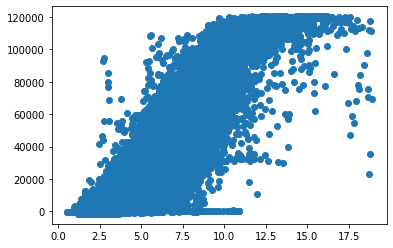

In [9]:
plt.scatter(X_train['wind_speed48M'], y_train)
plt.show()

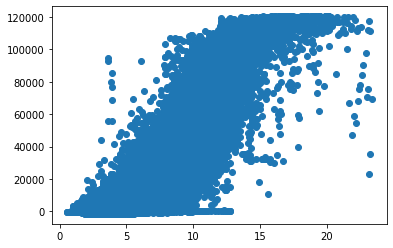

In [10]:
plt.scatter(X_train['wind_speed152M'], y_train)
plt.show()

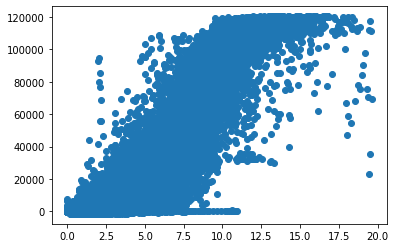

In [11]:
plt.scatter(X_train['wind_speed100MP10'], y_train)
plt.show()

In [12]:
#correlation of the fields
feat_corr = train_data.corr()
feat_corr

,wind_speed48M,wind_speed100M,wind_speed152M,wind_direction48M,wind_direction100M,wind_direction152M,wind_speed100MP10,wind_speed100MP30,wind_speed100MP30,wind_speed100MP40,wind_speed100MP50,wind_speed100MP60,wind_speed100MP70,wind_speed100MP80,wind_speed100MP90,interpolated,available_capacity,output
wind_speed48M,1.000000,0.982453,0.958376,0.126413,0.123056,0.121065,0.980281,0.981269,0.981838,0.982227,0.982453,0.982369,0.982194,0.981865,0.981349,-2.313416e-05,6.193204e-03,0.889447
wind_speed100M,0.982453,1.000000,0.992113,0.093161,0.094450,0.097180,0.998020,0.998975,0.999514,0.999802,0.999991,0.999808,0.999542,0.999067,0.998291,-2.677297e-05,5.655206e-02,0.888803
wind_speed152M,0.958376,0.992113,1.000000,0.071982,0.074658,0.079498,0.990102,0.991048,0.991628,0.991905,0.992099,0.991887,0.991613,0.991130,0.990248,-2.998525e-05,7.744337e-02,0.875016
wind_direction48M,0.126413,0.093161,0.071982,1.000000,0.948389,0.918411,0.090588,0.091225,0.091921,0.092738,0.093215,0.093544,0.094032,0.095121,0.096000,-1.697860e-03,-2.923861e-02,0.117044
wind_direction100M,0.123056,0.094450,0.074658,0.948389,1.000000,0.967467,0.092224,0.092726,0.093375,0.094042,0.094508,0.094722,0.095064,0.095921,0.096700,-1.365760e-03,-2.924203e-02,0.113851
wind_direction152M,0.121065,0.097180,0.079498,0.918411,0.967467,1.000000,0.095220,0.095619,0.096266,0.096887,0.097229,0.097394,0.097657,0.098456,0.099104,-1.084837e-03,-2.642469e-02,0.111899
wind_speed100MP10,0.980281,0.998020,0.990102,0.090588,0.092224,0.095220,1.000000,0.999414,0.998924,0.998509,0.997995,0.997481,0.996861,0.995924,0.994582,-2.615521e-05,5.494955e-02,0.885870
wind_speed100MP30,0.981269,0.998975,0.991048,0.091225,0.092726,0.095619,0.999414,1.000000,0.999656,0.999348,0.998956,0.998550,0.998043,0.997250,0.996089,-2.614688e-05,5.541125e-02,0.886977
wind_speed100MP30,0.981838,0.999514,0.991628,0.091921,0.093375,0.096266,0.998924,0.999656,1.000000,0.999787,0.999499,0.999186,0.998775,0.998106,0.997100,-2.610919e-05,5.625096e-02,0.887776
wind_speed100MP40,0.982227,0.999802,0.991905,0.092738,0.094042,0.096887,0.998509,0.999348,0.999787,1.000000,0.999790,0.999540,0.999205,0.998635,0.997737,-2.629489e-05,5.603817e-02,0.888227


<AxesSubplot:>

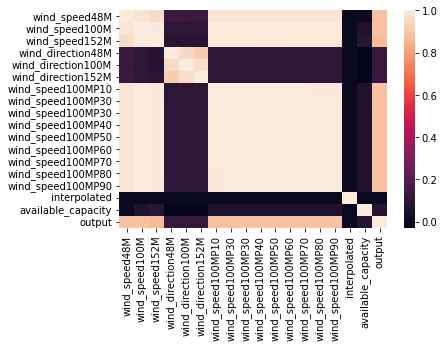

In [13]:
sns.heatmap(feat_corr)

Next, the input features and output label will be defined fro the training data

In [14]:
X_train = train_data.drop(['output', 'date'], axis = 1)
y_train = train_data['output']

In [15]:
#same features will be used for the test data
X_test = test_data.drop(['output', 'date'], axis = 1)
y_test = test_data['output']

In [16]:
lr = LinearRegression().fit(X_train, y_train)

In [17]:
score = round ( lr.score(X_train, y_train)* 100, 2)

make predicitons on the test data and compare result with y_test

In [18]:
pred = lr.predict(X_test)

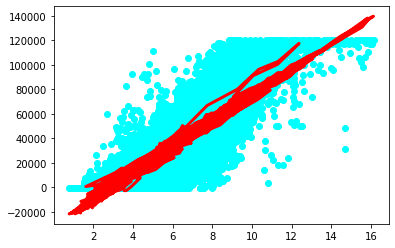

In [19]:
plt.scatter(X_test['wind_speed48M'], y_test, color= 'cyan')
plt.plot(X_test['wind_speed48M'], pred, color="red", linewidth=3)

Evaluation of Linear Regression

In [20]:
print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, pred))
print('Mean Square Error:', metrics.mean_squared_error(y_test, pred))
print('Root Mean Square Error:', np.sqrt(metrics.mean_squared_error(y_test, pred)))

Mean Absolute Error: 11907.483797595914
Mean Square Error: 250485883.0018962
Root Mean Square Error: 15826.745812133846


The difference between the predicted values and actual values will now be computed (Residual)

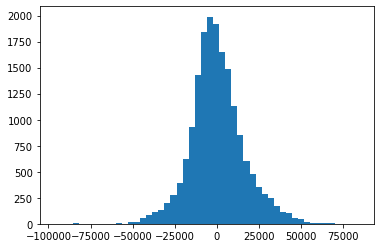

In [21]:
plt.hist((y_test-pred),bins=50);

Trying out XGBoost

In [22]:
Xtrain_array = np.array(X_train)
xgb = XGBRegressor().fit(Xtrain_array, y_train)

In [23]:
print ('XGB training accuracy is', round (xgb.score(Xtrain_array, y_train), 2)* 100)

XGB training accuracy is 93.0


In [24]:
xg_pred = xgb.predict (X_test)

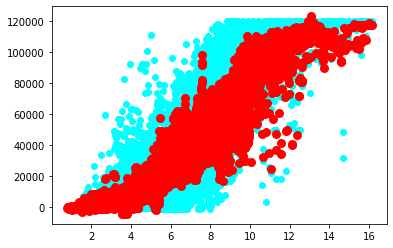

In [25]:
plt.scatter(X_test['wind_speed48M'], y_test, color= 'cyan')
plt.scatter(X_test['wind_speed48M'], xg_pred, color="red", linewidth=3)
plt.show()

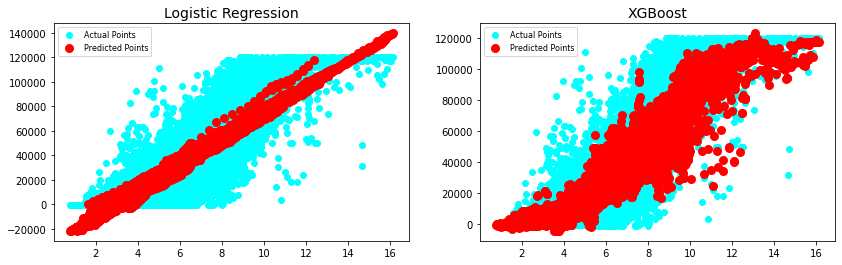

In [26]:
#COmparing the two classifier predictions
fig, axes = plt.subplots(1, 2, figsize=(14,4))
axes[0].set_title('Logistic Regression', fontsize = 14)
axes[1].set_title('XGBoost', fontsize = 14)
axes[0].scatter(X_test['wind_speed48M'], y_test, color= 'cyan', label = 'Actual Points')
axes[0].scatter(X_test['wind_speed48M'], pred, color="red", linewidth=3, label = 'Predicted Points')
axes[0].legend(fontsize = 8)

axes[1].scatter(X_test['wind_speed48M'], y_test, color= 'cyan', label = 'Actual Points')
axes[1].scatter(X_test['wind_speed48M'], xg_pred, color="red", linewidth=3, label = 'Predicted Points')
axes[1].legend(fontsize = 8)
plt.show()

XGBOOST Evaluation

In [27]:
print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, xg_pred))
print('Mean Square Error:', metrics.mean_squared_error(y_test, xg_pred))
print('Root Mean Square Error:', np.sqrt(metrics.mean_squared_error(y_test, xg_pred)))

Mean Absolute Error: 9727.85777732929
Mean Square Error: 211450089.53539675
Root Mean Square Error: 14541.32351388266


Could Normalizing the features make a difference ?

In [28]:
from sklearn.preprocessing import MinMaxScaler

In [29]:
minmax = MinMaxScaler()

In [30]:
Xnorm_train = minmax.fit_transform(X_train)

In [31]:
minmax_lr = LinearRegression().fit(Xnorm_train, y_train)
minmax_score = round ( minmax_lr.score(Xnorm_train, y_train)* 100, 2)
minmax_score

80.08

Normalsing gives thesame training results

Using the results from the features correlation. (feat_corr), the highly correlated features will be removed to see if there will be difference in results

In [32]:
#Using Pearson COrrelation
threshold = 0.8
columns = set()
for cols in range (len(feat_corr.columns)):
    for values in range (cols):
        if abs (feat_corr.iloc[cols, values]) > threshold:
            column = feat_corr.columns[cols]
            columns.add(column)
        


In [33]:
print (columns)

{'wind_direction152M', 'wind_speed152M', 'wind_speed100MP40', 'wind_speed100MP80', 'wind_speed100MP70', 'output', 'wind_speed100MP10', 'wind_speed100M', 'wind_speed100MP50', 'wind_speed100MP60', 'wind_speed100MP30', 'wind_speed100MP90', 'wind_direction100M'}


The training features will be selected without the items in columns

In [34]:
newX_train = train_data.drop(['date','wind_speed100MP40', 'wind_speed152M', 'wind_speed100M', 'wind_speed100MP60', 
                              'output', 'wind_speed100MP70', 'wind_direction152M', 'wind_speed100MP30', 'wind_speed100MP10',
                              'wind_speed100MP50', 'wind_speed100MP80', 'wind_speed100MP90', 'wind_direction100M'
                                 ], axis = 1)

In [35]:
newX_train

,wind_speed48M,wind_direction48M,interpolated,available_capacity
0,8.490,188.00,0,122400.0
1,8.395,190.75,1,122400.0
2,8.300,193.50,1,122400.0
3,8.205,196.25,1,122400.0
4,8.110,199.00,0,122400.0
...,...,...,...,...
52503,4.920,269.25,1,119000.0
52504,5.030,269.00,0,119000.0
52505,5.030,269.00,1,119000.0
52506,5.030,269.00,1,119000.0


In [36]:
newlr = LinearRegression().fit(newX_train, y_train)
score = round ( newlr.score(newX_train, y_train)* 100, 2)
score

79.53

In [37]:
newXtrain_array = np.array(newX_train)
newxgb = XGBRegressor().fit(newXtrain_array, y_train)

round (newxgb.score(newXtrain_array, y_train), 2)* 100

90.0

So far, the XGBoost classifier has performed best with a training accuracy of 93%, and RMSE of 14,541